# MDN_RNN
___
* MDN-RNN output: next latent vector z
* see training params
![title](RNN_Flow.png)

* ...macht keinen Sinn

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import json
from gym.utils import seeding


In [2]:
from pathlib import Path
path = str(Path(os.getcwd()).parent.parent)
import_path = str(Path(os.getcwd()).parent.parent.parent)

import sys
sys.path.insert(0,path)
from breakout.rnn.rnn import RNNModel, hps_sample, rnn_init_state
from breakout.vae.vae import ConvVAE

sys.path.insert(0, import_path)
from WorldModelsExperiments.breakout.model import Model, _process_frame

In [4]:
path = '/home/student/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200423'
rnn_path = path + '/tf_rnn'
series_path = path + '/series'
vae_path = path + '/tf_vae'
obs_path = path + '/record_noframeskip'
seq_len = 1000


## See MDN-RNN output
Observation and Action are taken from the recorded data, only the state as rnn output is again input for the rnn

In [5]:
model = Model(load_model=True, rnn_path=os.path.join(rnn_path, 'rnn.json'), vae_path=os.path.join(vae_path, 'vae.json'))

INFO:tensorflow:Model using cpu.


In [7]:
series = np.load(os.path.join(series_path,'series.npz'))
data_mu = series['mu'][:10]
data_logvar = series['logvar'][:10]
data_action = series['action'][:10]

In [9]:
data_mu[0].shape

(1000, 32)

In [10]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    #print('error with sampling ensemble, returning random', random_value)
    return random_value

In [11]:
def sample_z(mu, log_sigma):
    z =  mu + (np.exp(log_sigma)) * np_random.randn(*log_sigma.shape) * 0.5
    return z

In [12]:
z_ofwholeobs = np.zeros((seq_len, 32), dtype=np.float32)
z_ofwholeobs.shape

(1000, 32)

In [13]:
data_mu[5].shape

(1000, 32)

In [14]:
state = model.state
state.h[0].shape

(256,)

In [15]:
z = data_mu[0] + np.exp(data_logvar[0]/2.0) * np.random.randn(*data_logvar[0].shape)
z[0].shape

(32,)

In [16]:
np.concatenate([z[0], state.h[0]]).shape

(288,)

In [17]:
# observation (mu+logvar)+ action from collected data (series.npz), state from rnn
def generate_next_z(data_mu, data_logvar, data_action, model, temperatur=0.5, z_size=32):
    z = data_mu[0] + np.exp(data_logvar[0]/2.0) * np.random.randn(*data_logvar[0].shape)
    state = model.state 
       
    for idx in range(seq_len): 
        # h = np.concatenate([z[idx],state.h[idx]])

        input_x = np.concatenate((z.reshape((1, 1, 32)), data_action[idx].reshape((1, 1, 4))), axis=2)
        feed = {
            model.rnn.input_x: input_x,
            model.rnn.initial_state: state
            }
        [logmix, mean, logstd, next_state] = model.rnn.sess.run([
            model.rnn.out_logmix, model.rnn.out_mean, model.rnn.out_logstd, model.rnn.final_state],
            feed)
        
        chosen_log_pi = np.zeros(z_size)
        chosen_mu = np.zeros(z_size)
        chosen_log_sigma = np.zeros(z_size)
        
        #adjust temp
        logmix2 = np.copy(logmix) #/temperature
        logmix2 -= logmix2.max()
        logmix2 = np.exp(logmix2)
        logmix2 /= logmix2.sum(axis=1).reshape(z_size, 1)
        
        for j in range(z_size):
            idx = get_pi_idx(np.random.rand(), logmix2[j])
            chosen_log_pi[j] = idx
            chosen_mu[j] = mean[j, idx]
            chosen_log_sigma[j] = logstd[j,idx]
        
        rand_gaussian = np.random.randn(z_size)*np.sqrt(temperatur)
        next_z = chosen_mu + np.exp(chosen_log_sigma) * rand_gaussian      
        
        z_ofwholeobs[idx, :] = next_z.reshape(1,32)
 
        z = next_z
        state = next_state
        
    return z_ofwholeobs
        

todo: wie ist es am sinnvollsten? Observation/Action Pair gemeinsam aus gesammeltem Datensatz entnehmen (1), oder nur Action entnehmen(2), und Observation generieren. Aber macht das Sinn? Action sollte ja eigentlich auf Grund von Observation vorhergesagt werden. 

In [18]:
z_list = generate_next_z(data_mu[1], data_logvar[1], data_action[1], model)

In [19]:
z_list.shape

(1000, 32)

In [20]:
next_z_dec = model.vae.decode(z_list)
next_z_dec.shape

(1000, 64, 64, 3)

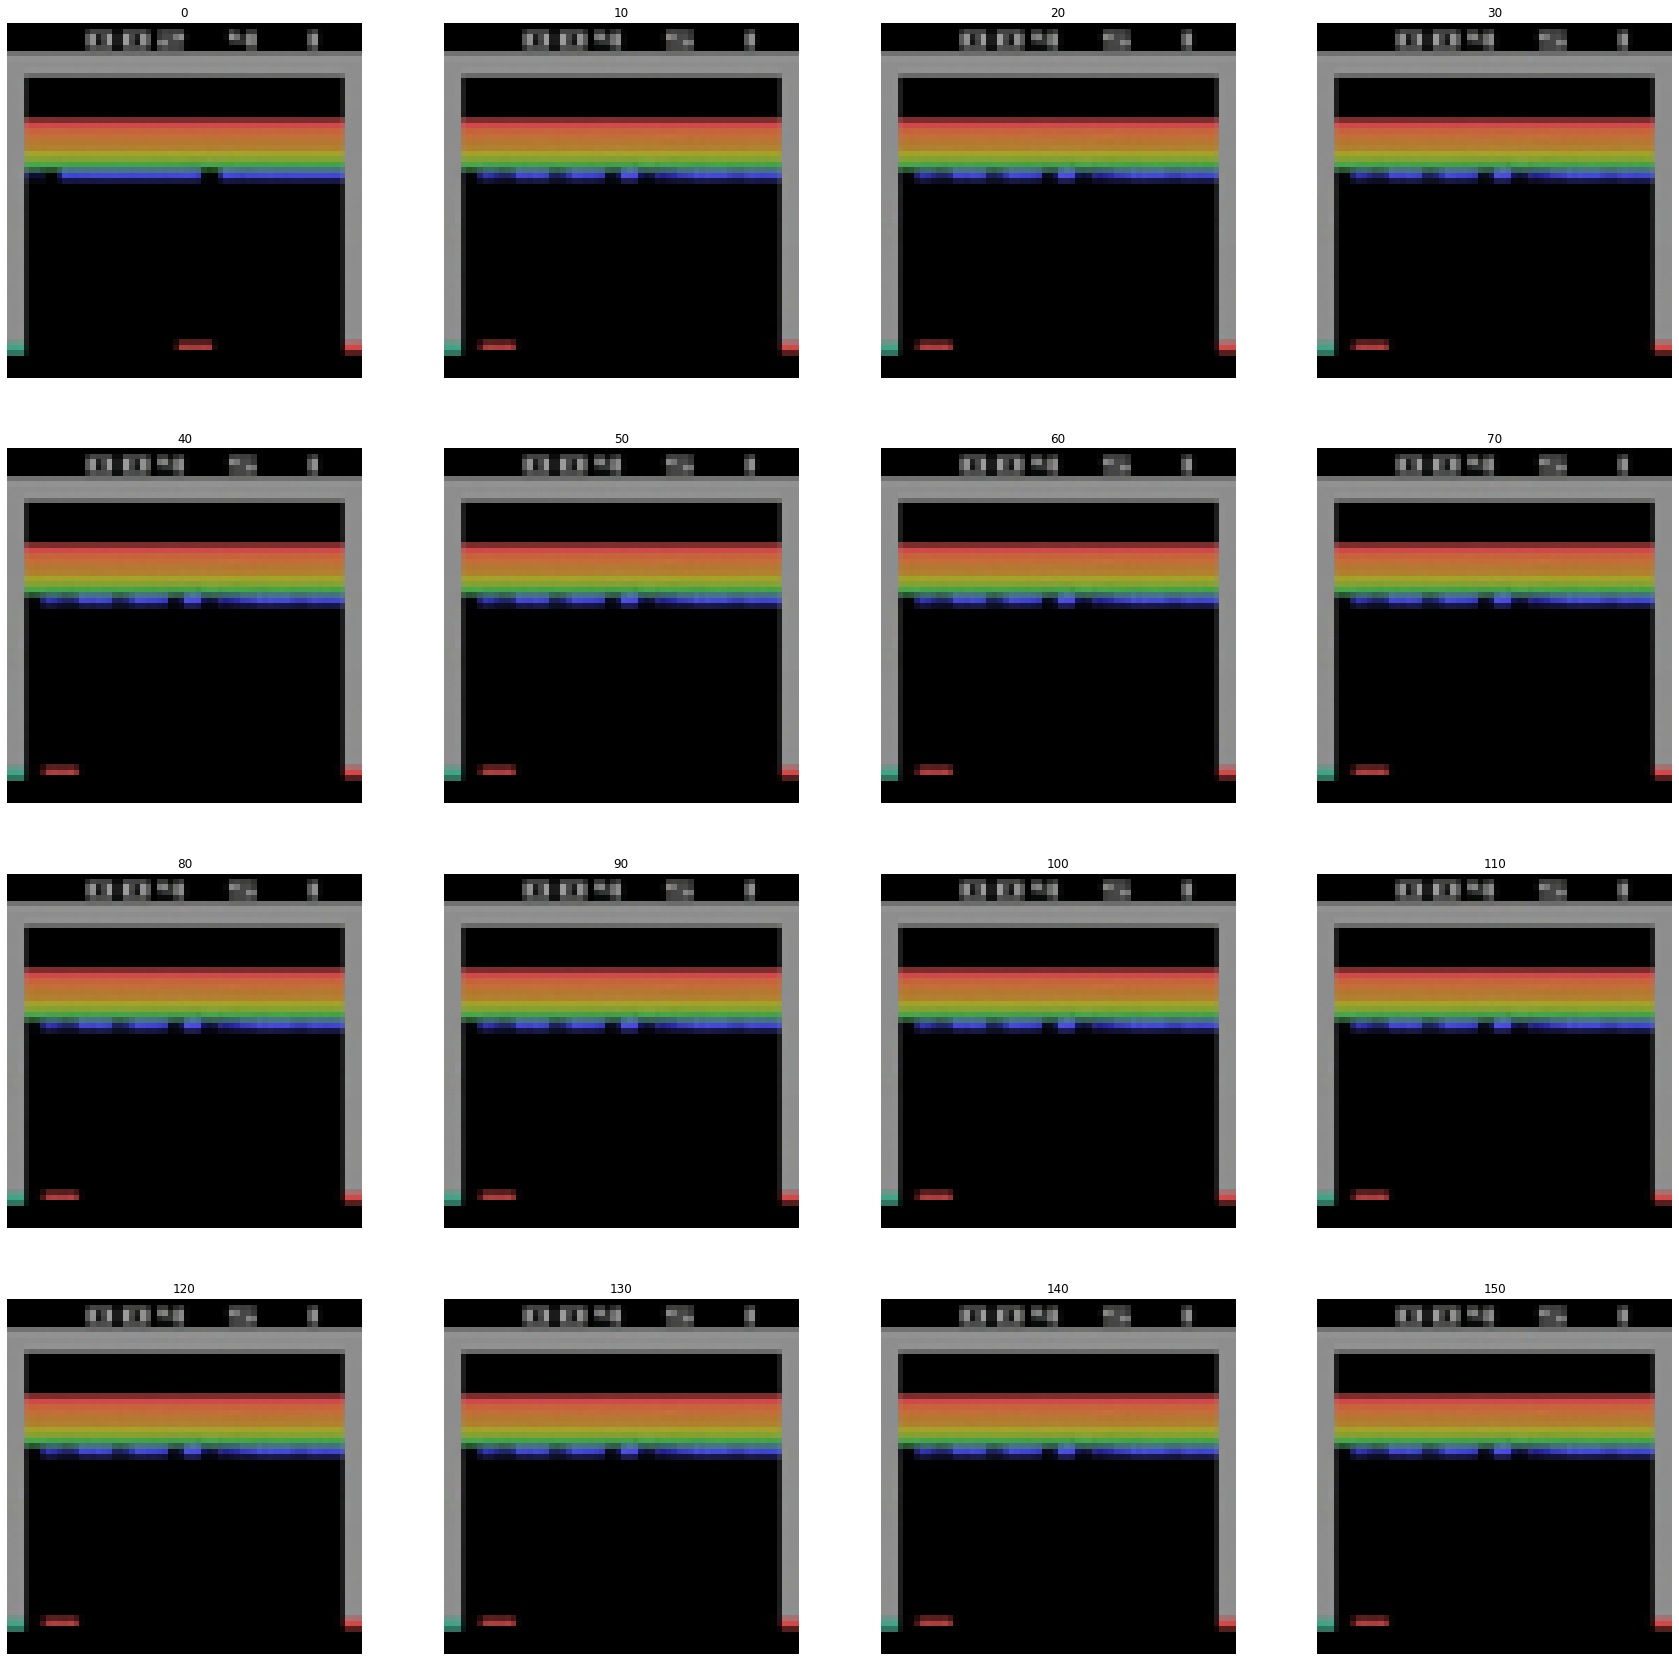

In [21]:
plt.figure(figsize=(30,30))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(next_z_dec[i*10])
    plt.title(i*10)
    plt.axis('off')
plt.show()

## Video Sequence

In [34]:
import base64
import imageio
import IPython

In [35]:
def embed_mp4(filename,video):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [77]:
filename = 'rnn_200420.mp4'
with imageio.get_writer(filename, mode='I') as video:    
    for image in range(399):
        video.append_data(np.array(next_z_dec[image]*255, dtype=np.uint8))
embed_mp4(filename,video)

In [78]:
data_action[5].shape

(500, 4)

In [79]:
data_action[5][0]

array([ 1.,  0.,  0.,  0.], dtype=float16)

In [22]:
action_list = []
for frame in data_action[5]:
    index =np.where(frame==1)
    action_list.append(index[0].item(0))

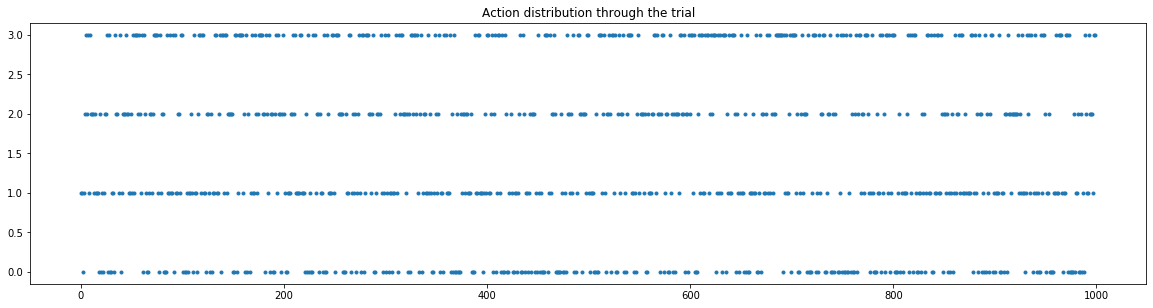

In [23]:
plt.figure(figsize=(20,4.8))
plt.plot(action_list, '.')
plt.title('Action distribution through the trial')
plt.show()

## Training Param

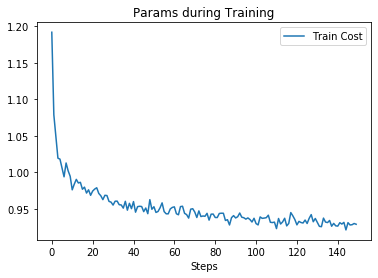

In [25]:
#with open(rnn_path +'/rnn_train_param.json', 'r') as file:
with open(rnn_path +'/rnn_train_param.json', 'r')as file:
    train_param = json.load(file)
train_cost = []
curr_learning_rate = []
for params in train_param:
    train_cost.append(params['train_cost'])
    
plt.plot(train_cost, label='Train Cost')
plt.legend(loc='upper right')
plt.xlabel('Steps')
plt.title('Params during Training')
plt.show()